In [1]:
import string
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ DATA ###

df = pd.read_csv('bbc-text.csv')

print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


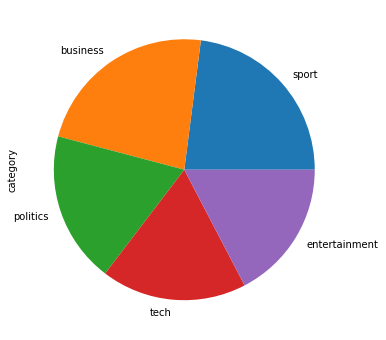

In [4]:
### LABEL DISTRIBUTION ###

df.category.value_counts().plot.pie(figsize=(6,6))

In [5]:
### SIMPLE CLEAN OF TEXT ###

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

In [6]:
### SPLIT INTO TRAIN/TEST ###

y = to_categorical(df.category.factorize()[0])

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=33, test_size=0.2)

In [7]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [8]:
### TRAIN WORD2VEC AND FASTTEXT ###

w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

In [9]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 200

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(1780, 200) (445, 200)


In [10]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 14539


In [11]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 0


In [12]:
### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    for embedding in list_emb:
        
        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [13]:
### TRY Concat_Emb ###

read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     2537000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     2537000     input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
### DEFINE DME AND CDME BLOCKS ###

def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, 100*2))(inp)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, 100*2))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [15]:
### DEFINE NETWORK WITH DME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     2537000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     2537000     input_4[0][0]                    
____________________________________________________________________________________________

In [16]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Epoch 1/20
13/13 - 8s - loss: 1.4712 - accuracy: 0.3864 - val_loss: 1.3488 - val_accuracy: 0.4719
Epoch 2/20
13/13 - 8s - loss: 1.2355 - accuracy: 0.5144 - val_loss: 1.2215 - val_accuracy: 0.5449
Epoch 3/20
13/13 - 9s - loss: 1.0699 - accuracy: 0.5805 - val_loss: 1.0908 - val_accuracy: 0.5899
Epoch 4/20
13/13 - 8s - loss: 0.8872 - accuracy: 0.6654 - val_loss: 0.8770 - val_accuracy: 0.6742
Epoch 5/20
13/13 - 8s - loss: 0.7226 - accuracy: 0.7453 - val_loss: 0.7533 - val_accuracy: 0.7135
Epoch 6/20
13/13 - 8s - loss: 0.9141 - accuracy: 0.7066 - val_loss: 1.4176 - val_accuracy: 0.5449
Epoch 7/20
13/13 - 8s - loss: 0.8701 - accuracy: 0.6829 - val_loss: 0.9323 - val_accuracy: 0.6517
Epoch 8/20
13/13 - 8s - loss: 0.6778 - accuracy: 0.7559 - val_loss: 0.7102 - val_accuracy: 0.7584
Epoch 9/20
13/13 - 9s - loss: 0.5715 - accuracy: 0.7953 - val_loss: 0.5090 - val_accuracy: 0.8146
Epoch 10/20
13/13 - 9s - loss: 0.4963 - accuracy: 0.8283 - val_loss: 0.5387 - val_accuracy: 0.8202
Epoch 11/20
13/13 -

In [17]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

               precision    recall  f1-score   support

     business       0.90      0.94      0.92        90
entertainment       0.95      0.78      0.86        88
     politics       0.95      0.81      0.87        73
        sport       0.91      0.98      0.95       106
         tech       0.83      0.97      0.89        88

     accuracy                           0.90       445
    macro avg       0.91      0.90      0.90       445
 weighted avg       0.91      0.90      0.90       445



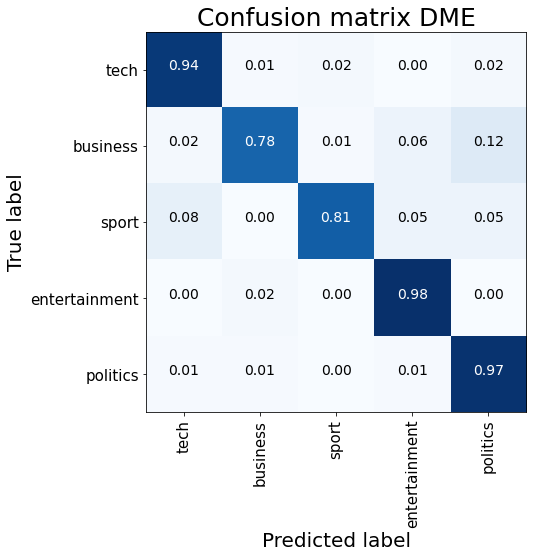

In [18]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

In [19]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     2537000     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 100)     2537000     input_7[0][0]                    
____________________________________________________________________________________________

In [20]:
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Epoch 1/20
13/13 - 10s - loss: 1.4908 - accuracy: 0.3571 - val_loss: 1.3832 - val_accuracy: 0.4438
Epoch 2/20
13/13 - 8s - loss: 1.2412 - accuracy: 0.5150 - val_loss: 1.2245 - val_accuracy: 0.5169
Epoch 3/20
13/13 - 10s - loss: 1.0761 - accuracy: 0.5849 - val_loss: 1.1371 - val_accuracy: 0.5899
Epoch 4/20
13/13 - 9s - loss: 0.8993 - accuracy: 0.6654 - val_loss: 0.9299 - val_accuracy: 0.6573
Epoch 5/20
13/13 - 8s - loss: 0.7464 - accuracy: 0.7235 - val_loss: 0.7301 - val_accuracy: 0.7079
Epoch 6/20
13/13 - 8s - loss: 0.5910 - accuracy: 0.7965 - val_loss: 0.5705 - val_accuracy: 0.8034
Epoch 7/20
13/13 - 9s - loss: 0.5288 - accuracy: 0.8290 - val_loss: 0.4330 - val_accuracy: 0.8596
Epoch 8/20
13/13 - 9s - loss: 0.4921 - accuracy: 0.8321 - val_loss: 0.5566 - val_accuracy: 0.8034
Epoch 9/20
13/13 - 8s - loss: 0.4805 - accuracy: 0.8502 - val_loss: 0.4810 - val_accuracy: 0.8483
Epoch 10/20
13/13 - 9s - loss: 0.3813 - accuracy: 0.8795 - val_loss: 0.3438 - val_accuracy: 0.8933
Epoch 11/20
13/13

In [21]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

               precision    recall  f1-score   support

     business       0.85      0.98      0.91        90
entertainment       0.94      0.82      0.87        88
     politics       0.79      0.96      0.86        73
        sport       0.96      0.94      0.95       106
         tech       0.96      0.78      0.86        88

     accuracy                           0.90       445
    macro avg       0.90      0.90      0.89       445
 weighted avg       0.91      0.90      0.90       445



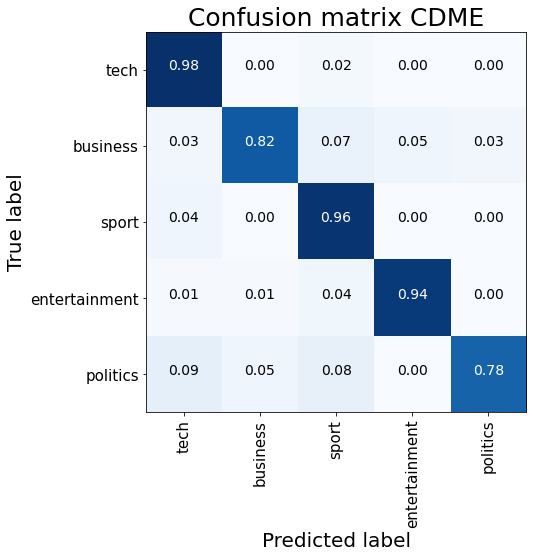

In [22]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()